# Max Over Time CNN

### Setup

In [1]:
import sys
sys.path.append('..')

import yaml
import torch
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import nltk
from nltk.corpus import stopwords

from dataset.qa_triplet_dataset import QATripletDataset
from model.max_over_time_cnn import MaxOverTimeCNN

with open('../config/notebook_cfg.yml', 'r') as fp:
    config = yaml.load(fp, Loader=yaml.FullLoader)
    
dataset = QATripletDataset(
        config['database_file'], config['database_table'], 
        config['vocab_file'])

dataloader = dataset.build_dataloader(
    batch_size=config['batch_size'], shuffle=True)

encoder = MaxOverTimeCNN(
    len(dataset.get_vocab()), config['wordvec_dim'], config['sentvec_dim'], 
    acceleration=True)

encoder.load_state_dict(torch.load(
    '../artifacts/models/max_over_time_cnn.pt', 
    map_location=torch.device('cpu')))

encoder.eval()

# grab a batch and encode anchor questions to vectors
batch = next(iter(dataloader))
question_str = batch['anc_str']
question_enc = encoder(batch['anc_idxs'])

# detach from pytorch and convert to numpy
question_enc = question_enc.detach().numpy()

/home/dylan/workspace/sentence-2-vec/virtualenv/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/dylan/workspace/sentence-2-vec/virtualenv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


[INFO]: using cpu device


### Nearest Neighbor Analysis

In [2]:
# compute nearest neighbors
neigh = NearestNeighbors(n_neighbors=5, metric='cosine')
nbrs = neigh.fit(question_enc)
nn_dist, nn_idx = nbrs.kneighbors(question_enc)

### Print Some Nearest Neighbor Groups

In [3]:
for idx in np.random.choice(len(nn_idx), size=10, replace=False):
    sample = question_str[nn_idx[idx, 0]]
    neighbors = [question_str[i] for i in nn_idx[idx, 1:]]
    
    print(f'Sample:\n\t{sample}')
    print(f'Neighbors:')
    for neighbor in neighbors:
        print(f'\t{neighbor}')
    print('')

Sample:
	peopl diabet eat sever small meal
Neighbors:
	sous safe diabet eat
	honey make diabet
	exactli diabet diet
	food diabet eat diarrhea

Sample:
	diabet glucos level two hr eat
Neighbors:
	diabet emerg caus high blood sugar
	effect copenhagen blood sugar
	diabet affect intellectu
	god diabet

Sample:
	found cure diabet
Neighbors:
	diabet drink boost
	chickpea flour good diabet
	way make chocol cooki diabet
	reliv diabet

Sample:
	import thing keep track diet person diabet
Neighbors:
	mani gram sugar white potato
	regist nurs need educ diabet
	much sugar kill
	cinnamon good peopl diabet

Sample:
	diabet complic
Neighbors:
	diabet itch genit
	long person live stage four kidney failur
	diabet contraind massag
	mean definit diabet

Sample:
	find diabet recip
Neighbors:
	diabet recip free
	sugar subsitut use diabet dessert recip
	find recip diabet dinner
	kind gestat recip diabet suffer

Sample:
	swine flu particularli danger someon diabet
Neighbors:
	twin diabet
	releas date day life

### Plot Nearest Neighbor Ordered Distances

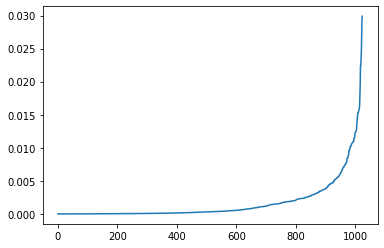

In [4]:
plt.plot(np.sort(nn_dist[:,1], axis=0))

### Cluster Sentence Vectors

In [10]:
from sklearn.cluster import DBSCAN, OPTICS

clustering = DBSCAN(eps=0.006, min_samples=10, n_jobs=-1, metric='cosine')
labels = clustering.fit_predict(question_enc)

# optics = OPTICS(min_samples=10, metric='cosine')
# optics.fit(question_enc)
# labels = optics.labels_

num_clusters = len(np.unique(labels))
perc_labeled = 100 * (len(labels[labels != -1]) / len(labels))
print(f'[Num. Clusters]: {num_clusters}, [Perc. Non-Outliers]: {perc_labeled:.1f}')

[Num. Clusters]: 5, [Perc. Non-Outliers]: 74.5


### Project Sentence Vectors

In [11]:
tsne = TSNE(n_components=3, metric='cosine')
question_proj = tsne.fit_transform(question_enc)

df = pd.DataFrame({
    'sentence': question_str,
    'vector': [x for x in question_enc],
    'label': labels,
    'pc_1': question_proj[:, 0],
    'pc_2': question_proj[:, 1],
    'pc_3': question_proj[:, 2],
})

fig = px.scatter_3d(
    df, x='pc_1', y='pc_2', z='pc_3', color='pc_3', 
    hover_data=['sentence'])
fig.update_traces(marker_size=5)
fig.layout.coloraxis.showscale = False
fig.update_layout(
    title='Projected Question Vector Manifold',
    height=500,
    showlegend=False
)
fig.show()

### Cluster Summaries

In [12]:
# get list standard stop words and add some custom ones to this list
stop_words = stopwords.words('english')
extras = ['diabetes', '?', '.', '!', '<unk>']
stop_words += extras

# initialize word stemmer
stemmer = nltk.stem.PorterStemmer()

# stem stop words
stop_words = [stemmer.stem(word) for word in stop_words]

# add a summary column
df['summary'] = None

# add column for average cluster vector
df['avg_vector'] = None

# infer cluster topics
for label in sorted(df['label'].unique()):
    # get all samples with this label
    samples = df[df['label'] == label]['sentence']
    
    # get all vectors with this label
    vectors = np.stack(df[df['label'] == label]['vector'].to_numpy())
    
    # compute average vec for this cluster label
    avg_vector = np.mean(vectors, axis=0)
    
    # add average vector to dataframe
    df.loc[df['label'] == label, 'avg_vector'] = df.loc[df['label'] == label, 'avg_vector'].map(
        lambda x: avg_vector)
    
    # convert samples to a list
    samples = samples.tolist()
    
    # tokenize samples by whitespace
    tokens = [[word for word in sentence.split(' ')] for sentence in samples]
    
    # flatten samples list
    tokens = [inner for outer in tokens for inner in outer]
    
    # stem tokens
    tokens = [stemmer.stem(token) for token in tokens]
    
    # filter stopwords
    tokens = [token for token in tokens if not token in stop_words]
    
    # get token frequencies
    fdist = nltk.FreqDist(tokens)
    
    # get summary string from 5 most frequent tokens
    summary = ' '.join([token for token, _ in fdist.most_common(5)])
    
    # add summary string to dataframe
    df.loc[df['label'] == label, 'summary'] = summary
    
    
print('Coarse Cluster Summaries:\n')
for i, summary in enumerate(df['summary'].unique()):
    print(f'{i+1}. {summary}')

Coarse Cluster Summaries:

1. type sugar insulin blood one
2. type cau one two get
3. diet food eat good recip
4. blood sugar insulin level gluco
5. cau effect eye get affect


In [13]:
fig = px.scatter_3d(
    df, x='pc_1', y='pc_2', z='pc_3', color='summary', 
    hover_data=['summary', 'sentence'])
fig.update_traces(marker_size=5)
fig.update_layout(
    title='Projected Question Vector Manifold',
    legend={'title': 'Cluster Summaries', 'itemclick': 'toggleothers'},
    height=500,
)
fig.show()